In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

KeyError: 'CONDA_DEFAULT_ENV'

In [12]:
import torch
import numpy as np
import tensorly as tl
import scipy.signal
import scipy.io
import matplotlib.pyplot as plt
import sklearn.model_selection

import itertools

print(torch.cuda.is_available)
print(torch.cuda.device_count)
print(torch.cuda.current_device)
print(torch.cuda.get_device_name(0))

<function is_available at 0x000001D17F1AE050>
<function current_device at 0x000001D17F2C7EB0>
Quadro P2000


In [13]:
import sys
sys.path.append(r'C:\Users\sabatini\Documents\GitHub')
%load_ext autoreload
%autoreload 2
from tensor_regression import multinomial_tensor_regression as mtr

import tensor_regression.util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [231]:
labels = scipy.io.loadmat('C:/Users/sabatini/Documents/currtens/allLabels.mat', simplify_cells=True)['allLabels']
tensor = scipy.io.loadmat('C:/Users/sabatini/Documents/currtens/tensor.mat', simplify_cells=True)['tensor']
timepoints = scipy.io.loadmat('C:/Users/sabatini/Documents/currtens/timepoints_for_tensor.mat', simplify_cells=True)['timepoints_for_tensor']

# Load file_path
#file_path = r'C:\Users\sabatini\Documents\currtens\cpmlr.pkl'
#import pickle
#with open(file_path, 'rb') as f:
#    obj = pickle.load(f)
#Bcp_before = obj.return_Bcp_final()
# Show Bcp_before
#print(Bcp_before)
# Make Bcp_before a tensor
#torch.cuda.empty_cache()
#torch.cuda.memory.max_split_size_mb = 256  # setting it to 256MB
#DEVICE = tensor_regression.util.set_device(use_GPU=True)
#Bcp_before = torch.tensor(Bcp_before[0]).to(DEVICE)
# Make Bcp_forinit an iterable of the tensors Bcp_before
#Bcp_forinit = [Bcp_before]

In [222]:
print(f'Input data shapes:')
print(f'labels: {labels.shape}')
print(f'tensor: {tensor.shape}')
print(f'timepoints: {timepoints.shape}')

Input data shapes:
labels: (40,)
tensor: (111, 450, 40)
timepoints: (450,)


(array([5320.,  560.,  620.,  570.,  480.,  550.,  620.,  640.,  450.,
         530.,  330.,  560.,  380.,  370.,  520.,  760.,  580.,  240.,
         360.,  320.,  200.,  170.,  120.,  110.,  140.,  150.,  150.,
         150.,   80.,   70.,  120.,   50.,   20.,   50.,   60.,   40.,
         130.,  110.,  100.,   40.,   90.,   80.,  100.,   40.,   50.,
          70.,   70.,   60.,   50.,   70.,   50.,    0.,   30.,   20.,
           0.,   20.,   20.,   10.,   30.,   20.,   10.,   20.,   30.,
          20.,   30.,   20.,    0.,   20.,    0.,    0.,   30.,   10.,
          10.,   20.,   30.,    0.,   10.,    0.,    0.,    0.,    0.,
           0.,   10.,    0.,    0.,    0.,    0.,    0.,   10.,    0.,
           0.,    0.,    0.,    0.,   10.,    0.,    0.,    0.,    0.,
          10.]),
 array([8.48246918e-17, 4.37413944e-02, 8.74827889e-02, 1.31224183e-01,
        1.74965578e-01, 2.18706972e-01, 2.62448367e-01, 3.06189761e-01,
        3.49931155e-01, 3.93672550e-01, 4.37413944e-01, 4.

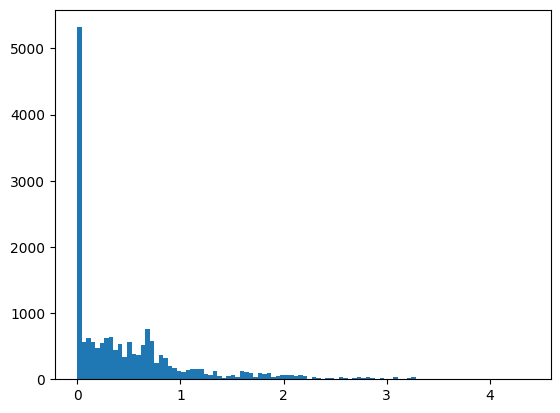

In [186]:
plt.figure()
plt.hist(tensor[0].reshape(-1), 100)

In [232]:
X = np.array(np.nan_to_num(tensor).transpose((2,0,1)), dtype=np.float32)
#X = (X - np.mean(X, axis=1)[:,None,:])
y = np.array(labels, dtype=np.int64)
print(f'X: {X.shape}, y: {y.shape}')

# y[y==1] = 0
# y[y>=2] = 1
# y[y==2] = 0
# y[y==3] = 1


DEVICE = tensor_regression.util.set_device(use_GPU=True)

u, c = np.unique(y, return_counts=True)
wei = c.sum() / c
wei = wei*4
print(wei)

hyperparameters = {}
hyperparameters['L2'] = [0.0125] #[0.0011] #[0.0125] #[0.0005] #[0.0, 0.001, 0.002, 0.004, 0.01, 0.02, 0.04]
hyperparameters['lr'] = [0.007] #[0.005] #[0.05] #[0.0003, 0.001, 0.003, 0.01, 0.03]
hyperparameters['rank'] = [2] #[4] #[1,2,3,4]
hyperparameters['Bcp_init_scale'] = [0.625] #[0.625] #[0.5, 1.0, 2.0]
hyperparameters['non_negative'] = [[True, False, False]] #[[True, True, True]] #[[False, False, False], [True, False, False], [False, True, False], [True, True, False]]
hyperparameters['iteration'] = list(np.arange(1)) #list(np.arange(5))

results = {}
for ii, h_vals in enumerate(itertools.product(*hyperparameters.values())):
    h_dict = {key: hv for key, hv in zip(hyperparameters.keys(), h_vals)}
    print(f'hyperparameters: {h_dict}')

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5, shuffle=True, stratify=y)

    cpmlr = mtr.CP_logistic_regression(
        X_train,
        y_train, 
        rank=h_dict['rank'],
        non_negative=h_dict['non_negative'],
        weights=None,
        Bcp_init=None,
        Bcp_init_scale=h_dict['Bcp_init_scale'],
        device=DEVICE,
        softplus_kwargs={
            'beta': 50,
            'threshold':1
        }
    )

    # cpmlr.fit(
    #     lambda_L2=0.000, 
    #     max_iter=200, 
    #     tol=1e-50, 
    #     patience=10,
    #     weights=weights,
    #     verbose=2,
    #     running_loss_logging_interval=1,
    #     LBFGS_kwargs={
    #         'lr' : 10000, 
    #         'max_iter' : 20, 
    #         'max_eval' : None, 
    #         'tolerance_grad' : 1e-07, 
    #         'tolerance_change' : 1e-09, 
    #         'history_size' : 100, 
    #         'line_search_fn' : "strong_wolfe"
    #     }
    #  )

    cpmlr.fit_Adam(
        lambda_L2=h_dict['L2'],
        max_iter=40000, 
        tol=1e-5, 
        patience=100,
        weights=wei,
        verbose=2,
        Adam_kwargs={
                'lr' : h_dict['lr'], 
    #                             'betas' : (0.9, 0.999), 
    #                             'eps' : 1e-08, 
    #                             'weight_decay' : 0, 
                'amsgrad' : True
            }
         )

    # # print(time.time() - tic)
    # print(f'loss: {cpmlr.loss_running[-1]}')

    # loss_all.append(cpmlr.loss_running[-1])

    logit, pred = cpmlr.predict(X=X_test, y_true=y_test)
    cm = mtr.confusion_matrix(pred, y_test)
    acc_val = np.sum(np.diag(cm))/np.sum(cm)

    logit, pred = cpmlr.predict(X=X_train, y_true=y_train)
    cm = mtr.confusion_matrix(pred, y_train)
    acc_train = np.sum(np.diag(cm))/np.sum(cm)

    # Make neuron- and time-shuffled data
    X_train_shuffled = X_train.copy()
    X_train_shuffled = X_train_shuffled[:, np.random.permutation(X_train_shuffled.shape[1]), :]
    X_train_shuffled = X_train_shuffled[:, :, np.random.permutation(X_train_shuffled.shape[2])]
    logit, pred = cpmlr.predict(X=X_train_shuffled, y_true=y_train)
    cm = mtr.confusion_matrix(pred, y_train)
    acc_train_shuffled = np.sum(np.diag(cm))/np.sum(cm)

    # Make trial-shuffled cm
    logit, pred = cpmlr.predict(X=X_train[np.random.permutation(X_train.shape[0])], y_true=y_train)
    cm = mtr.confusion_matrix(pred, y_train)
    acc_train_shuffled_trial = np.sum(np.diag(cm))/np.sum(cm)
    
    print(f'Accuracy test: {acc_val:.3f}, Accuracy train: {acc_train:.3f}, Accuracy neuron and time shuffled: {acc_train_shuffled:.3f}, Accuracy trial shuffled: {acc_train_shuffled_trial:.3f}')

    
    results[ii] = {}
    results[ii]['acc_val'] = acc_val
    results[ii]['acc_train'] = acc_train
    results[ii]['acc_train_shuffleNeurXTime'] = acc_train_shuffled
    results[ii]['acc_train_shuffleTrial'] = acc_train_shuffled_trial
    results[ii]['loss_running'] = cpmlr.loss_running
    results[ii]['loss_train_final'] = cpmlr.loss_running[-1]
    results[ii]['hyperparameters'] = h_dict


X: (40, 111, 450), y: (40,)
device: 'cuda'
[16. 16. 16. 16.]
hyperparameters: {'L2': 0.0125, 'lr': 0.007, 'rank': 2, 'Bcp_init_scale': 0.625, 'non_negative': [True, False, False], 'iteration': 0}
Iteration: 0, Loss: 1.6363593339920044
Iteration: 1, Loss: 1.6327582597732544
Iteration: 2, Loss: 1.629193902015686
Iteration: 3, Loss: 1.6256699562072754
Iteration: 4, Loss: 1.622187614440918
Iteration: 5, Loss: 1.6187429428100586
Iteration: 6, Loss: 1.6153291463851929
Iteration: 7, Loss: 1.6119428873062134
Iteration: 8, Loss: 1.6084824800491333
Iteration: 9, Loss: 1.600579023361206
Iteration: 10, Loss: 1.5807960033416748
Iteration: 11, Loss: 1.5588513612747192
Iteration: 12, Loss: 1.53207266330719
Iteration: 13, Loss: 1.519351601600647
Iteration: 14, Loss: 1.518083930015564
Iteration: 15, Loss: 1.582252025604248
Iteration: 16, Loss: 1.5427699089050293
Iteration: 17, Loss: 1.5228772163391113
Iteration: 18, Loss: 1.49131178855896
Iteration: 19, Loss: 1.5734889507293701
Iteration: 20, Loss: 1.5

Accuracy TRAIN: 1.0


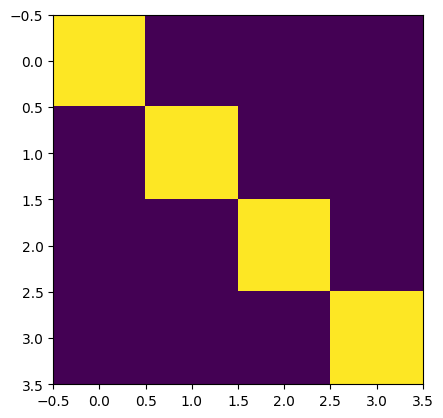

In [82]:
logit, pred = cpmlr.predict(X=X_train, y_true=y_train)
cm = mtr.confusion_matrix(pred, y_train)
acc = np.sum(np.diag(cm))/np.sum(cm)

print(f'Accuracy TRAIN: {acc}')

plt.figure()
plt.imshow(cm)

Accuracy TEST: 1.0


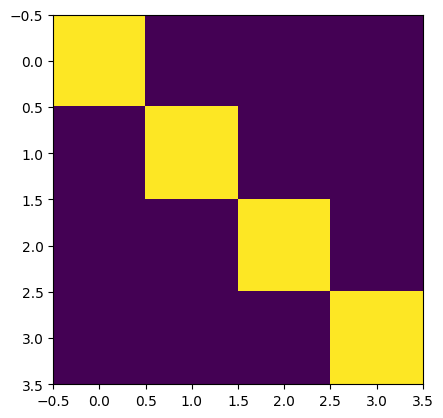

In [58]:
logit, pred = cpmlr.predict(X=X_test, y_true=y_test)
cm = mtr.confusion_matrix(pred, y_test)
acc = np.sum(np.diag(cm))/np.sum(cm)

print(f'Accuracy TEST: {acc}')

plt.figure()
plt.imshow(cm)

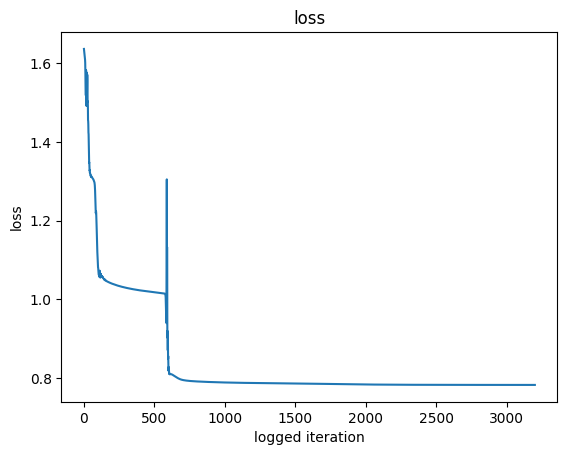

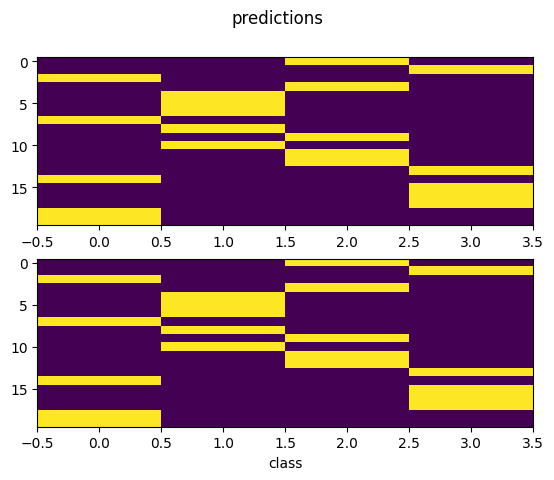

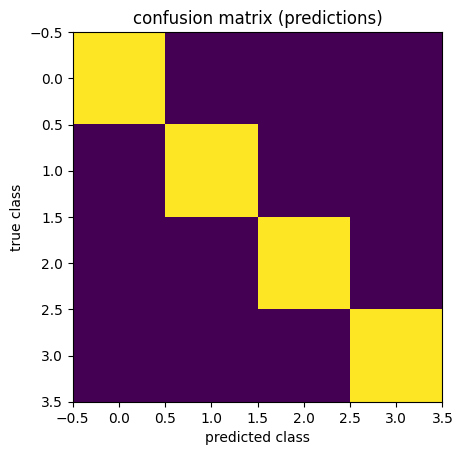

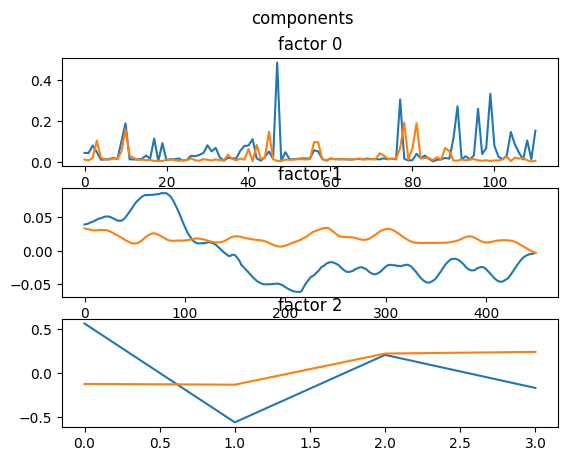

In [233]:
cpmlr.plot_outputs()

In [49]:
cpmlr.make_confusion_matrix()

(array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 1.0)

In [208]:
import pickle

# Specify the file path to save the mdl
file_path = r'C:\Users\sabatini\Documents\currtens\cpmlr.pkl'

with open(file_path, 'wb') as file:
    # Save cpmlr
    pickle.dump(cpmlr, file)

print('cpmlr saved successfully.')

cpmlr saved successfully.


In [209]:
import os

# Save cpmlr to .mat file
file_path=r'C:\Users\sabatini\Documents\currtens'
Bcp_final = #
for ii, val in enumerate(Bcp_final):
    scipy.io.savemat(os.path.join(file_path, f'factor_{ii}.mat'), {'factor': val})

In [236]:
labels = scipy.io.loadmat('C:/Users/sabatini/Documents/currtens2/allLabels.mat', simplify_cells=True)['allLabels']
tensor = scipy.io.loadmat('C:/Users/sabatini/Documents/currtens2/tensor.mat', simplify_cells=True)['tensor']
timepoints = scipy.io.loadmat('C:/Users/sabatini/Documents/currtens2/timepoints_for_tensor.mat', simplify_cells=True)['timepoints_for_tensor']
Bcp_before = cpmlr.return_self()
# Show Bcp_before
#print(Bcp_before)
# Make Bcp_before a tensor
#torch.cuda.empty_cache()
#torch.cuda.memory.max_split_size_mb = 256  # setting it to 256MB
#DEVICE = tensor_regression.util.set_device(use_GPU=True)
#Bcp_before = torch.tensor(Bcp_before[0]).to(DEVICE)
# Make Bcp_forinit an iterable of the tensors Bcp_before
#Bcp_forinit = [Bcp_before]

[array([[0.04461544, 0.02097469],
       [0.04429464, 0.01868184],
       [0.0807822 , 0.02040371],
       [0.04876059, 0.10447925],
       [0.02044627, 0.02080152],
       [0.02147882, 0.02185111],
       [0.02262478, 0.02077762],
       [0.02035949, 0.0243517 ],
       [0.0221721 , 0.02242614],
       [0.09967577, 0.05175898],
       [0.1878804 , 0.15906376],
       [0.02186664, 0.03144854],
       [0.02130131, 0.02005868],
       [0.02117032, 0.01952197],
       [0.02353439, 0.02063586],
       [0.03166826, 0.01933894],
       [0.02418186, 0.02015369],
       [0.11421677, 0.0167309 ],
       [0.01609349, 0.01757565],
       [0.09188338, 0.01667771],
       [0.01886413, 0.02065027],
       [0.02214728, 0.02123308],
       [0.02199424, 0.01918906],
       [0.02463605, 0.01717493],
       [0.01789786, 0.01938369],
       [0.02021985, 0.01910796],
       [0.03070855, 0.02469075],
       [0.0283207 , 0.01875212],
       [0.03495255, 0.01769947],
       [0.04406737, 0.02240038],
       [0

In [237]:
#old_cpmlr=[cpmlr]

X = np.array(np.nan_to_num(tensor).transpose((2,0,1)), dtype=np.float32)
#X = (X - np.mean(X, axis=1)[:,None,:])
y = np.array(labels, dtype=np.int64)
print(f'X: {X.shape}, y: {y.shape}')

# y[y==1] = 0
# y[y>=2] = 1
# y[y==2] = 0
# y[y==3] = 1


#DEVICE = tensor_regression.util.set_device(use_GPU=True)

u, c = np.unique(y, return_counts=True)
wei = c.sum() / c
wei = wei*4
print(wei)

hyperparameters = {}
hyperparameters['L2'] = [0.0125] #[0.0011] #[0.0125] #[0.0005] #[0.0, 0.001, 0.002, 0.004, 0.01, 0.02, 0.04]
hyperparameters['lr'] = [0.007] #[0.005] #[0.05] #[0.0003, 0.001, 0.003, 0.01, 0.03]
hyperparameters['rank'] = [2] #[4] #[1,2,3,4]
hyperparameters['Bcp_init_scale'] = [0.625] #[0.625] #[0.5, 1.0, 2.0]
hyperparameters['non_negative'] = [[True, False, False]] #[[True, True, True]] #[[False, False, False], [True, False, False], [False, True, False], [True, True, False]]
hyperparameters['iteration'] = list(np.arange(1)) #list(np.arange(5))

results = {}
for ii, h_vals in enumerate(itertools.product(*hyperparameters.values())):
    h_dict = {key: hv for key, hv in zip(hyperparameters.keys(), h_vals)}
    print(f'hyperparameters: {h_dict}')

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5, shuffle=True, stratify=y)

    cpmlr = mtr.CP_logistic_regression(
        X_train,
        y_train, 
        rank=h_dict['rank'],
        non_negative=h_dict['non_negative'],
        weights=None,
        Bcp_init=Bcp_before,
        Bcp_init_scale=h_dict['Bcp_init_scale'],
        device=DEVICE,
        softplus_kwargs={
            'beta': 50,
            'threshold':1
        }
    )

    # cpmlr.fit(
    #     lambda_L2=0.000, 
    #     max_iter=200, 
    #     tol=1e-50, 
    #     patience=10,
    #     weights=weights,
    #     verbose=2,
    #     running_loss_logging_interval=1,
    #     LBFGS_kwargs={
    #         'lr' : 10000, 
    #         'max_iter' : 20, 
    #         'max_eval' : None, 
    #         'tolerance_grad' : 1e-07, 
    #         'tolerance_change' : 1e-09, 
    #         'history_size' : 100, 
    #         'line_search_fn' : "strong_wolfe"
    #     }
    #  )

    cpmlr.fit_Adam(
        lambda_L2=h_dict['L2'],
        max_iter=40000, 
        tol=1e-5, 
        patience=100,
        weights=wei,
        verbose=2,
        Adam_kwargs={
                'lr' : h_dict['lr'], 
    #                             'betas' : (0.9, 0.999), 
    #                             'eps' : 1e-08, 
    #                             'weight_decay' : 0, 
                'amsgrad' : True
            }
         )

    # # print(time.time() - tic)
    # print(f'loss: {cpmlr.loss_running[-1]}')

    # loss_all.append(cpmlr.loss_running[-1])

    logit, pred = cpmlr.predict(X=X_test, y_true=y_test)
    cm = mtr.confusion_matrix(pred, y_test)
    acc_val = np.sum(np.diag(cm))/np.sum(cm)

    logit, pred = cpmlr.predict(X=X_train, y_true=y_train)
    cm = mtr.confusion_matrix(pred, y_train)
    acc_train = np.sum(np.diag(cm))/np.sum(cm)

    # Make neuron- and time-shuffled data
    X_train_shuffled = X_train.copy()
    X_train_shuffled = X_train_shuffled[:, np.random.permutation(X_train_shuffled.shape[1]), :]
    X_train_shuffled = X_train_shuffled[:, :, np.random.permutation(X_train_shuffled.shape[2])]
    logit, pred = cpmlr.predict(X=X_train_shuffled, y_true=y_train)
    cm = mtr.confusion_matrix(pred, y_train)
    acc_train_shuffled = np.sum(np.diag(cm))/np.sum(cm)

    # Make trial-shuffled cm
    logit, pred = cpmlr.predict(X=X_train[np.random.permutation(X_train.shape[0])], y_true=y_train)
    cm = mtr.confusion_matrix(pred, y_train)
    acc_train_shuffled_trial = np.sum(np.diag(cm))/np.sum(cm)
    
    print(f'Accuracy test: {acc_val:.3f}, Accuracy train: {acc_train:.3f}, Accuracy neuron and time shuffled: {acc_train_shuffled:.3f}, Accuracy trial shuffled: {acc_train_shuffled_trial:.3f}')

    
    results[ii] = {}
    results[ii]['acc_val'] = acc_val
    results[ii]['acc_train'] = acc_train
    results[ii]['acc_train_shuffleNeurXTime'] = acc_train_shuffled
    results[ii]['acc_train_shuffleTrial'] = acc_train_shuffled_trial
    results[ii]['loss_running'] = cpmlr.loss_running
    results[ii]['loss_train_final'] = cpmlr.loss_running[-1]
    results[ii]['hyperparameters'] = h_dict

X: (40, 111, 450), y: (40,)
[16. 16. 16. 16.]
hyperparameters: {'L2': 0.0125, 'lr': 0.007, 'rank': 2, 'Bcp_init_scale': 0.625, 'non_negative': [True, False, False], 'iteration': 0}


TypeError: optimizer can only optimize Tensors, but one of the params is list